In [52]:
import os
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [8]:
# !pip install omegaconf
# !pip install pycocotools

In [10]:
import sys
sys.path.append('./efficientdet-pytorch-master')
# sys.path

In [87]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain, DetBenchPredict

In [88]:
config = get_efficientdet_config('tf_efficientdet_d0')
net = EfficientDet(config, pretrained_backbone=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /Users/michaelka/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


In [16]:
config

{'name': 'tf_efficientdet_d0', 'backbone_name': 'tf_efficientnet_b0', 'backbone_args': {'drop_path_rate': 0.2}, 'backbone_indices': None, 'image_size': [512, 512], 'num_classes': 90, 'min_level': 3, 'max_level': 7, 'num_levels': 5, 'num_scales': 3, 'aspect_ratios': [[1.0, 1.0], [1.4, 0.7], [0.7, 1.4]], 'anchor_scale': 4.0, 'pad_type': 'same', 'act_type': 'swish', 'norm_layer': None, 'norm_kwargs': {'eps': 0.001, 'momentum': 0.01}, 'box_class_repeats': 3, 'fpn_cell_repeats': 3, 'fpn_channels': 64, 'separable_conv': True, 'apply_resample_bn': True, 'conv_after_downsample': False, 'conv_bn_relu_pattern': False, 'use_native_resize_op': False, 'downsample_type': 'max', 'upsample_type': 'nearest', 'redundant_bias': True, 'head_bn_level_first': False, 'head_act_type': None, 'fpn_name': None, 'fpn_config': None, 'fpn_drop_path_rate': 0.0, 'alpha': 0.25, 'gamma': 1.5, 'label_smoothing': 0.0, 'legacy_focal': False, 'jit_loss': False, 'delta': 0.1, 'box_loss_weight': 50.0, 'soft_nms': False, 'max

In [17]:
# net

In [18]:
def get_num_of_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [19]:
get_num_of_params(net)

3880067

In [21]:
import torch

In [26]:
x = torch.rand(5, 3, 512, 512)
x.shape

torch.Size([5, 3, 512, 512])

In [31]:
cls, box = net(x)

In [36]:
len(cls), len(box)

(5, 5)

In [41]:
cls[0].shape

torch.Size([5, 810, 64, 64])

In [43]:
box[1].shape

torch.Size([5, 36, 32, 32])

## Dataset

In [49]:
from PIL import Image

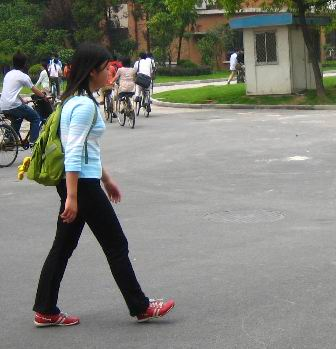

In [50]:
IMG_PATH = './PennFudanPed/PNGImages/'
image_name = 'FudanPed00015.png'

image = Image.open(IMG_PATH+image_name)
image

In [58]:
image_array = np.array(image)
print(image_array.shape)
print(image_array[:5,:5,0])

(349, 336, 3)
[[30 30 32 42 34]
 [38 30 33 33 26]
 [37 33 43 32 40]
 [32 46 67 35 43]
 [53 63 82 46 38]]


### Single prediction without training

In [78]:
from torchvision.transforms import functional as TF

In [74]:
image_tensor = torch.tensor(image_array.transpose(2, 0, 1)[np.newaxis,:], dtype=torch.float32)
image_tensor /= 255

- EfficientDet accepts only square images?

In [79]:
IMG_SIZE = 256

In [80]:
image_tensor = TF.resize(image_tensor, (IMG_SIZE, IMG_SIZE))

In [81]:
image_tensor.shape

torch.Size([1, 3, 256, 256])

In [82]:
cls, box = net(image_tensor)

In [85]:
for c in cls:
    print(c.shape)

torch.Size([1, 810, 32, 32])
torch.Size([1, 810, 16, 16])
torch.Size([1, 810, 8, 8])
torch.Size([1, 810, 4, 4])
torch.Size([1, 810, 2, 2])


In [86]:
for b in box:
    print(b.shape)

torch.Size([1, 36, 32, 32])
torch.Size([1, 36, 16, 16])
torch.Size([1, 36, 8, 8])
torch.Size([1, 36, 4, 4])
torch.Size([1, 36, 2, 2])


In [90]:
bench_predict = DetBenchPredict(net)

In [91]:
out = bench_predict(image_tensor)

In [93]:
out.shape

torch.Size([1, 100, 6])

In [103]:
# out

In [99]:
out[0,:,5]

tensor([54., 54., 82., 14., 82.,  8., 17., 82., 54., 82., 82., 16., 53., 72.,
         2.,  2.,  4., 70., 54., 82., 56., 54., 61., 70., 50., 76., 54., 18.,
        70., 16.,  1., 83., 40., 50., 80., 53., 21., 53., 76., 45., 45., 54.,
        28., 72., 53., 23., 67., 44., 28., 70., 30., 50., 13., 82., 70., 19.,
        16., 29., 54., 49., 90., 28., 53., 42., 77., 49., 22., 26., 87., 54.,
        70., 37., 78., 50., 16., 16.,  9., 14., 90.,  8., 69., 33., 18., 28.,
        19., 15., 50., 49., 23., 11., 17., 16., 19.,  9., 16., 65., 10., 69.,
        58., 76.], grad_fn=<SelectBackward>)

In [100]:
out[0,:,4]

tensor([0.8332, 0.8033, 0.7607, 0.7407, 0.7384, 0.6924, 0.6800, 0.6556, 0.6413,
        0.6304, 0.6206, 0.5938, 0.5884, 0.5794, 0.5793, 0.5765, 0.5689, 0.5629,
        0.5569, 0.5558, 0.5455, 0.5390, 0.5345, 0.5313, 0.5287, 0.5082, 0.5017,
        0.4932, 0.4835, 0.4811, 0.4698, 0.4648, 0.4641, 0.4593, 0.4580, 0.4388,
        0.4316, 0.4294, 0.4292, 0.4287, 0.4200, 0.4193, 0.4183, 0.4177, 0.4156,
        0.4061, 0.4041, 0.4033, 0.4024, 0.3996, 0.3987, 0.3946, 0.3933, 0.3851,
        0.3794, 0.3768, 0.3745, 0.3739, 0.3732, 0.3696, 0.3655, 0.3647, 0.3601,
        0.3596, 0.3584, 0.3573, 0.3567, 0.3564, 0.3551, 0.3530, 0.3524, 0.3507,
        0.3503, 0.3481, 0.3479, 0.3420, 0.3418, 0.3418, 0.3392, 0.3381, 0.3358,
        0.3356, 0.3334, 0.3315, 0.3309, 0.3281, 0.3274, 0.3221, 0.3211, 0.3204,
        0.3192, 0.3191, 0.3184, 0.3171, 0.3168, 0.3163, 0.3162, 0.3150, 0.3145,
        0.3144], grad_fn=<SelectBackward>)

In [94]:
out[0,0,:]

tensor([278.1701,  42.3531, 304.7966,  64.9763,   0.8332,  54.0000],
       grad_fn=<SliceBackward>)

In [95]:
out[0,1,:]

tensor([59.2739, 62.3061, 87.7948, 69.9501,  0.8033, 54.0000],
       grad_fn=<SliceBackward>)

In [96]:
COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

In [102]:
len(COCO_INSTANCE_CATEGORY_NAMES)

91

In [105]:
COCO_INSTANCE_CATEGORY_NAMES[54]

'sandwich'